In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
strain = 'BY4741'
locus = 'FKS1-HS1'

# Notebook to classify variants using a Gaussian mixture model

## Import libraries

In [2]:
import os
import pandas as pd
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Specify paths

In [3]:
# Input
aggdata_outpath = '../../results/df/avg_scores.csv'
missing_mut_path = '../growth_data/validation_DMS_missing_estimates.csv'
fungamr_path = '../fungamr/fungamrmut_filtered.tsv'

# Output
classified_outpath = f'../classified/{"_".join([strain,locus])}/'
if not os.path.exists(classified_outpath):
    os.makedirs(classified_outpath)

graph_outpath = '../graphs/'
fungamr_outpath = '../fungamr/'

## GMM

In [4]:
master = pd.read_csv(aggdata_outpath).rename(columns={"Mutated_seq": "locus", "fitness_T2": "s", "lower_err_T2": "min_s", "upper_err_T2": "max_s"})
master

,strain,paralog,hotspot,locus,compound,Nham_aa,aa_seq,aa_pos,alt_aa,wt_aa,s,min_s,max_s
0,BY4741,FKS1,HS1,FKS1-HS1,none,0,FLVLSLRDP,not-applicable,not-applicable,not-applicable,-0.005178,0.004919,0.004919
1,BY4741,FKS1,HS1,FKS1-HS1,none,1,*LVLSLRDP,639,*,F,-0.364729,0.130043,0.130043
2,BY4741,FKS1,HS1,FKS1-HS1,none,1,ALVLSLRDP,639,A,F,-0.009024,0.069635,0.069635
3,BY4741,FKS1,HS1,FKS1-HS1,none,1,DLVLSLRDP,639,D,F,-0.031286,0.044307,0.044307
4,BY4741,FKS1,HS1,FKS1-HS1,none,1,ELVLSLRDP,639,E,F,0.029142,0.013222,0.013222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,R1158,FKS2,HS2,FKS2-HS2,anidulafungin,1,SWVRRYTL,1372,S,D,-0.086795,0.162708,0.162708
3696,R1158,FKS2,HS2,FKS2-HS2,anidulafungin,1,TWVRRYTL,1372,T,D,0.106099,0.005660,0.005660
3697,R1158,FKS2,HS2,FKS2-HS2,anidulafungin,1,VWVRRYTL,1372,V,D,-0.169164,0.060304,0.060304
3698,R1158,FKS2,HS2,FKS2-HS2,anidulafungin,1,WWVRRYTL,1372,W,D,0.379459,0.056126,0.056126


In [5]:
GMMdf = master[(master.strain == strain) & (master.locus == locus)
               ].groupby(["compound", "aa_seq"]
                         )[["s", "min_s", "max_s"]
                           ].agg(s = ("s", "first"),
                                 min_s = ("min_s", "first"),
                                 max_s = ("max_s", "first")
                                 ).reset_index()
GMMdf

,compound,aa_seq,s,min_s,max_s
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564
...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537
685,none,VLVLSLRDP,0.028834,0.013133,0.013133
686,none,WLVLSLRDP,0.048208,0.010552,0.010552


### Optimize model

In [6]:
# Set specific seed
seed = 25 # Set value for repetability

# Initialize dictionary to store parameters for each condition
model_dict = {}

# Specify order of conditions
lcomp = ['none','dox','anidulafungin','caspofungin','micafungin']

# Optimize model for every condition (here, compound) separately
for j,c in enumerate(lcomp):
    if c in GMMdf.compound.unique():
        # The goal is to minimize AIC and BIC, but mostly BIC
        X = GMMdf[GMMdf.compound == c].s.values.reshape(-1,1)
        N = np.arange(1, 6)
        models = [None for i in range(len(N))] # testing up to 1-5 components
        # 5 is the max number of biologically relevant classes: deleterious, WT-like, intermediary, resistant, very resistant
        for i in range(len(N)):
            models[i] = GaussianMixture(n_components=N[i], random_state = seed).fit(X, y=None)

        # Compute AIC and BIC
        AIC = [m.aic(X) for m in models]
        BIC = [m.bic(X) for m in models]
    
        # Save parameters to dictionary
        model_dict[c.title()] = (N, AIC, BIC)

In [7]:
model_df = pd.DataFrame.from_dict(model_dict, orient='index', columns=['components','AIC','BIC']).reset_index(names='compound')
model_df = model_df.explode(['components','AIC','BIC']).melt(['compound','components'], var_name='IC')

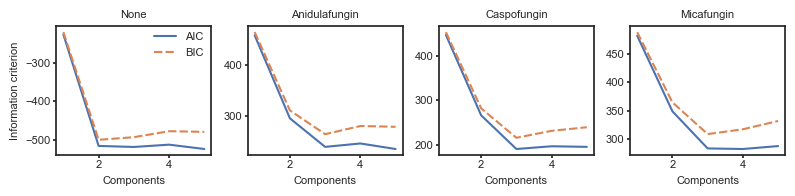

In [8]:
# Purge graph space
sns.set_theme(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

fig = sns.relplot(data=model_df, col='compound', x='components', y='value',
                  hue='IC', style='IC',
                  kind='line', height=2,
                  facet_kws = {'sharey':False, 'despine':False})

fig.set_titles(row_template='{row_name}', col_template='{col_name}')
fig.set_axis_labels('Components', 'Information criterion')
sns.move_legend(fig, 'upper left', bbox_to_anchor=(.175, .88), title=None)
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus])}_GMM_BIC.svg', format='svg', dpi=300)

In [9]:
for c,y in model_dict.items(): # for each compound
    print(c, np.argmin(y[1])+1) # display the optimal number of components for the GMM

None 5
Anidulafungin 5
Caspofungin 3
Micafungin 4


### Run model

In [10]:
# Define the number of components (number of mods)
mods = 3

# Define range
mini = round(GMMdf.s.min()) - 1
maxi = round(GMMdf.s.max()) + 1

# Initialize list of df
proba_list = []

for i,c in enumerate(model_dict.keys()): # For every compound
    X = GMMdf[GMMdf.compound == c.lower()].s.values.reshape(-1,1)
    M_best = GaussianMixture(n_components=mods, random_state = seed).fit(X, y=None)
    GMMdf.loc[GMMdf.compound == c.lower(), 'label'] = M_best.predict(X)
    
    x = np.linspace(mini, maxi, len(GMMdf[GMMdf.compound == c.lower()]))
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    # Convert to dataframe
    indiv_df = pd.DataFrame(pdf_individual)
    indiv_df['x'] = x
    indiv_df = indiv_df.melt(id_vars = 'x', var_name = 'label', value_name='p(x)')
    indiv_df['compound'] = c
    proba_list.append(indiv_df)

proba_df = pd.concat(proba_list, ignore_index=True)
hist_df = GMMdf.copy()
hist_df['compound'] = hist_df.compound.apply(lambda x: x.title())

In [11]:
if os.path.exists(f'{classified_outpath}/thresholds.csv'):
    stddf = pd.read_csv(f'{classified_outpath}/thresholds.csv')
else:
    stddf = pd.DataFrame()
    print("Need to calculate thresholds. Will not display in next plot.")

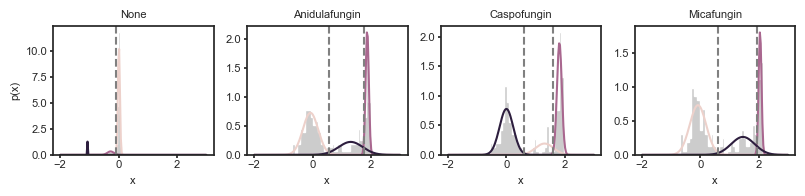

In [12]:
# Purge graph space
sns.set_theme(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

fig = sns.relplot(proba_df, col='compound',
                  x='x', y='p(x)', hue='label',
                  kind='line', height=2, legend=False,
                  facet_kws = {'sharey':False, 'despine':False}
                 )

fig.set_titles(row_template='{row_name}', col_template='{col_name}')

for i,c in enumerate(proba_df.compound.unique()):
    fig.axes[0][i].hist(hist_df[hist_df.compound == c].s,
                        30, density=True, histtype='stepfilled',
                        color='.8')
    if not stddf.empty:
        fig.axes[0][i].axvline(x=stddf[stddf.compound==c.lower()].val.tolist()[0], ls='--', color='grey')
        fig.axes[0][i].axvline(x=stddf[stddf.compound==c.lower()].val.tolist()[1], ls='--', color='grey')
    
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus])}_GMM_densities.svg', format='svg', dpi=300)

In [13]:
# Looking at the predicted labels for each condition and the mean value to properly convert the label into a class
label_mean = GMMdf.groupby(['compound', 'label'])[['s']].agg(['size','mean']).reset_index().sort_values(by=[('compound',''),('s','mean')])
label_mean

compound label    s          
                        size      mean
0   anidulafungin   0.0   82 -0.072983
2   anidulafungin   2.0   38  1.288478
1   anidulafungin   1.0   52  1.875478
5     caspofungin   2.0   79 -0.000470
3     caspofungin   0.0   20  1.213283
4     caspofungin   1.0   73  1.803961
6      micafungin   0.0   88 -0.089084
8      micafungin   2.0   44  1.425358
7      micafungin   1.0   40  2.045599
11           none   2.0    1 -1.063235
10           none   1.0   15 -0.286382
9            none   0.0  156  0.008749

### Convert classification labels

In [14]:
class_dict = {}
class_list = ['WT-like', 'intermediary', 'resistant']
none_list = {'FKS1-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
             'FKS1-HS2': ['WT-like', 'WT-like', 'WT-like'],
             'FKS1-HS3': ['deleterious', 'slightly deleterious', 'WT-like'],
             'FKS2-HS1': ['slightly deleterious', 'WT-like', 'WT-like'],
             'FKS2-HS2': ['slightly deleterious', 'WT-like', 'WT-like']
            }
dox_list = {'FKS1-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
            'FKS2-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
            'FKS2-HS2': ['deleterious', 'slightly deleterious', 'WT-like']
           }

for c in label_mean.compound.unique():
    class_dict[c] = {}

i=0
for c,l in zip(label_mean.compound, label_mean.label):
    i = len(class_dict[c])
    if c in ['anidulafungin','caspofungin','micafungin']:
        class_dict[c][l] = class_list[i]
    elif c=='none':
        if locus in none_list.keys():
            class_dict[c][l] = none_list[locus][i]
        else:
            class_dict[c][l] = 'error'
    elif c=='dox':
        if locus in dox_list.keys():
            class_dict[c][l] = dox_list[locus][i]
        else:
            class_dict[c][l] = 'error'
    else:
        class_dict[c][l] = 'error'

class_dict

{'anidulafungin': {0.0: 'WT-like', 2.0: 'intermediary', 1.0: 'resistant'},
 'caspofungin': {2.0: 'WT-like', 0.0: 'intermediary', 1.0: 'resistant'},
 'micafungin': {0.0: 'WT-like', 2.0: 'intermediary', 1.0: 'resistant'},
 'none': {2.0: 'deleterious', 1.0: 'slightly deleterious', 0.0: 'WT-like'}}

In [15]:
GMMdf['rclass'] = GMMdf.apply(lambda row: class_dict[row.compound][row.label], axis=1)
GMMdf

,compound,aa_seq,s,min_s,max_s,label,rclass
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238,0.0,WT-like
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191,2.0,intermediary
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571,0.0,WT-like
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555,2.0,intermediary
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564,0.0,WT-like
...,...,...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019,0.0,WT-like
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537,1.0,slightly deleterious
685,none,VLVLSLRDP,0.028834,0.013133,0.013133,0.0,WT-like
686,none,WLVLSLRDP,0.048208,0.010552,0.010552,0.0,WT-like


In [16]:
GMMdf.to_csv(f'{classified_outpath}/raw_classification.csv')

## Breakdown: number of variants per class

In [17]:
GMMdf = pd.read_csv(f'{classified_outpath}/raw_classification.csv', index_col=0)

In [18]:
GMMdf.groupby(['compound', 'rclass'])[['s']].agg(['size','median'])

s          
                                   size    median
compound      rclass                             
anidulafungin WT-like                82 -0.088398
              intermediary           38  1.413885
              resistant              52  1.882616
caspofungin   WT-like                79 -0.002947
              intermediary           20  1.319337
              resistant              73  1.830777
micafungin    WT-like                88 -0.114466
              intermediary           44  1.461403
              resistant              40  2.050969
none          WT-like               156  0.009129
              deleterious             1 -1.063235
              slightly deleterious   15 -0.292238

## Refine classification (resolve overlaps)

To resolve overlaps , I use the distributions to define thresholds. However, because only the "resistant" and "WT-like" distributions (as called by the GMM) are narrow, we define the thresholds only for these groups. "Intermediary", "deleterious", etc end up being the label of variants which **did not** cross the thresholds.

### Step 1 - Set thresholds from narrow distributions

In [19]:
zthresh = 2.5 # set threshold in z-score

In [20]:
distri_params = GMMdf.groupby(['compound','rclass'])[['s']].agg(['mean','std']).reset_index()
distri_params.columns = [x[0] if x[1]=='' else x[1] for x in distri_params.columns]
distri_params['lower_bound'] = distri_params['mean'] - zthresh*distri_params['std']
distri_params['upper_bound'] = distri_params['mean'] + zthresh*distri_params['std']
distri_params

,compound,rclass,mean,std,lower_bound,upper_bound
0,anidulafungin,WT-like,-0.072983,0.257097,-0.715725,0.569759
1,anidulafungin,intermediary,1.288478,0.380094,0.338242,2.238714
2,anidulafungin,resistant,1.875478,0.049711,1.751199,1.999756
3,caspofungin,WT-like,-0.000470,0.237008,-0.592989,0.592049
4,caspofungin,intermediary,1.213283,0.245466,0.599619,1.826947
5,caspofungin,resistant,1.803961,0.088596,1.582471,2.025451
6,micafungin,WT-like,-0.089084,0.273760,-0.773484,0.595317
7,micafungin,intermediary,1.425358,0.383877,0.465665,2.385051
8,micafungin,resistant,2.045599,0.045249,1.932476,2.158722
9,none,WT-like,0.008749,0.034756,-0.078141,0.095639


In [21]:
stdlist = []

for c in distri_params.compound.unique():
    if c in ['caspofungin','micafungin','anidulafungin']:
        stdlist.append([c, 'low',
                        distri_params.loc[(distri_params.compound == c)
                                          & (distri_params.rclass == 'WT-like'),
                                          'upper_bound'
                                         ].values[0]
                       ])
        if locus in ['FKS1-HS1','FKS1-HS3','FKS2-HS1']:
            stdlist.append([c, 'up',
                            distri_params.loc[(distri_params.compound == c)
                                              & (distri_params.rclass == 'resistant'),
                                              'lower_bound'
                                             ].values[0]                    
                           ])
        elif locus in ['FKS1-HS2','FKS2-HS2']:
            stdlist.append([c, 'up',
                            distri_params.loc[(distri_params.compound == c)
                                              & (distri_params.rclass == 'intermediary'),
                                              'upper_bound'
                                             ].values[0]
                           ])
        else:
            print('Please define locus-specific bound')
    else:
        stdlist.append([c, 'low',
                        distri_params.loc[(distri_params.compound == c)
                                          & (distri_params.rclass == 'WT-like'),
                                          'lower_bound'
                                         ].values[0]
                       ])
        stdlist.append([c, 'up', None])
    
stddf = pd.DataFrame(stdlist, columns=['compound', 'thresh', 'val'])
stddf.to_csv(f'{classified_outpath}/thresholds.csv')
stddf

,compound,thresh,val
0,anidulafungin,low,0.569759
1,anidulafungin,up,1.751199
2,caspofungin,low,0.592049
3,caspofungin,up,1.582471
4,micafungin,low,0.595317
5,micafungin,up,1.932476
6,none,low,-0.078141
7,none,up,NaN


<Axes: xlabel='compound', ylabel='s'>

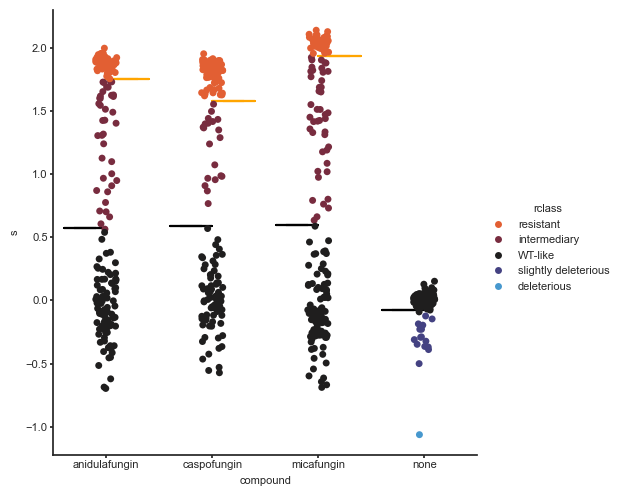

In [22]:
fig = sns.catplot(GMMdf, x='compound', y='s', hue='rclass',
            hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
            palette='icefire_r',
            #alpha=.3
                 )

sns.boxplot(stddf, x='compound', y='val',
            hue='thresh', hue_order=['low','up'], palette=['black','orange'], fill=False,
            legend=False)

### Step 2 - Refine classification

In [23]:
def refine_class(v, comp, threshdf):
    wtbound = threshdf.loc[(threshdf.compound == comp)
                           & (threshdf.thresh == 'low'),
                           'val'].values[0]
    resbound = threshdf.loc[(threshdf.compound == comp)
                           & (threshdf.thresh == 'up'),
                           'val'].values[0]
    
    if (comp in ['none','dox']) & (v > -.7):
        if (v >= wtbound):
            return 'WT-like'
        else:
            return 'slightly deleterious'
    elif (comp in ['none','dox']) & (v < -.7):
        return 'deleterious'
    else:        
        if v <= wtbound:
            return 'WT-like'
        elif v >= resbound:
            return 'resistant'
        else:
            return 'intermediary'

In [24]:
GMMdf['refined_class'] = GMMdf.apply(lambda row: refine_class(row.s, row.compound, stddf), axis=1)
GMMdf

,compound,aa_seq,s,min_s,max_s,label,rclass,refined_class
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238,0.0,WT-like,WT-like
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191,2.0,intermediary,intermediary
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571,0.0,WT-like,WT-like
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555,2.0,intermediary,WT-like
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564,0.0,WT-like,WT-like
...,...,...,...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019,0.0,WT-like,WT-like
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537,1.0,slightly deleterious,slightly deleterious
685,none,VLVLSLRDP,0.028834,0.013133,0.013133,0.0,WT-like,WT-like
686,none,WLVLSLRDP,0.048208,0.010552,0.010552,0.0,WT-like,WT-like


<Axes: xlabel='compound', ylabel='s'>

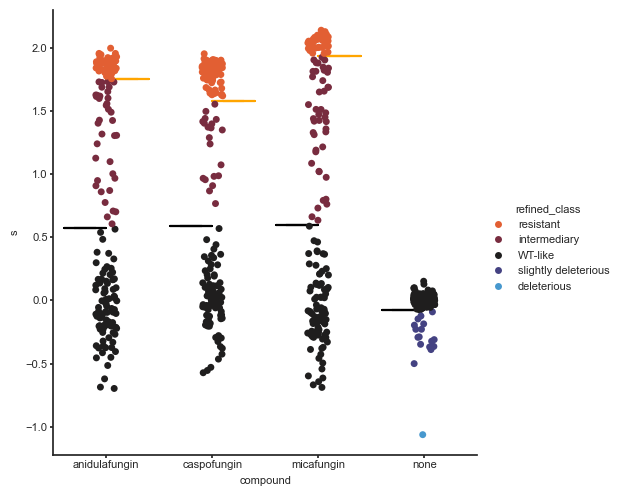

In [25]:
fig = sns.catplot(GMMdf, x='compound', y='s', hue='refined_class',
            hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
            palette='icefire_r',
            #alpha=.3
                 )

sns.boxplot(stddf, x='compound', y='val',
            hue='thresh', hue_order=['low','up'], palette=['black','orange'], fill=False,
            legend=False)

### Step 3 - Collapse classification (sensitive/resistant)

In [26]:
GMMdf['sensres'] = GMMdf.refined_class.replace({'intermediary':'resistant',
                                                'WT-like':'sensitive', 'slightly deleterious':'sensitive', 'deleterious':'deleterious'})
GMMdf

,compound,aa_seq,s,min_s,max_s,label,rclass,refined_class,sensres
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238,0.0,WT-like,WT-like,sensitive
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191,2.0,intermediary,intermediary,resistant
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571,0.0,WT-like,WT-like,sensitive
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555,2.0,intermediary,WT-like,sensitive
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564,0.0,WT-like,WT-like,sensitive
...,...,...,...,...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019,0.0,WT-like,WT-like,sensitive
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537,1.0,slightly deleterious,slightly deleterious,sensitive
685,none,VLVLSLRDP,0.028834,0.013133,0.013133,0.0,WT-like,WT-like,sensitive
686,none,WLVLSLRDP,0.048208,0.010552,0.010552,0.0,WT-like,WT-like,sensitive


In [27]:
GMMdf.to_csv(f'{classified_outpath}/refined_classification.csv')

### Step 4 - Compare with validations

At this stage, we need to perform a linear regression with growth data from reconstructed mutants, i.e. run [this notebook](./20240129_validations_test3.ipynb)

### Step 5 - Add missing FKS1-HS1 mutants

Here I'm adding a little snippet to include FKS1-HS1 mutants originally missing from the DMS dataset but that were individually reconstructed and for which we have an inferred DMS score

In [28]:
missmut = pd.read_csv(missing_mut_path, index_col=0)[['compound','aa_seq','estimated_s']]
missmut.rename(columns={'estimated_s':'s'}, inplace=True)
missmut['Nham_aa'] = 1
missmut.head(4)

,compound,aa_seq,s,Nham_aa
8,anidulafungin,CLVLSLRDP,1.852916,1
9,caspofungin,CLVLSLRDP,1.854670,1
10,micafungin,CLVLSLRDP,1.888163,1
11,none,CLVLSLRDP,0.099555,1


In [29]:
# Replacing the two DMS datapoints which were overestimated to replace by validation data
# Note: even though values obtained with caspofungin and anidulafungin were very well correlated, we still replace with the inferred score + that way we don't have duplicate values in the df
GMMdf.drop(GMMdf[GMMdf.aa_seq.isin(missmut.aa_seq.unique())].index, inplace=True)

In [30]:
if locus == 'FKS1-HS1':
    slpAA = pd.concat([GMMdf, missmut], ignore_index=True)
elif locus in ['FKS1-HS2','FKS1-HS3','FKS2-HS2']:
    print('No mutants added')
else:
    print('Locus not supported')
GMMdf

,compound,aa_seq,s,min_s,max_s,label,rclass,refined_class,sensres
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238,0.0,WT-like,WT-like,sensitive
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191,2.0,intermediary,intermediary,resistant
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571,0.0,WT-like,WT-like,sensitive
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555,2.0,intermediary,WT-like,sensitive
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564,0.0,WT-like,WT-like,sensitive
...,...,...,...,...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019,0.0,WT-like,WT-like,sensitive
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537,1.0,slightly deleterious,slightly deleterious,sensitive
685,none,VLVLSLRDP,0.028834,0.013133,0.013133,0.0,WT-like,WT-like,sensitive
686,none,WLVLSLRDP,0.048208,0.010552,0.010552,0.0,WT-like,WT-like,sensitive


In [45]:
GMMdf['refined_class'] = GMMdf.apply(lambda row: refine_class(row.s, row.compound, stddf), axis=1)
GMMdf['sensres'] = GMMdf.refined_class.replace({'intermediary':'resistant',
                                                'WT-like':'sensitive', 'slightly deleterious':'sensitive', 'deleterious':'deleterious'})
GMMdf.to_csv(f'{classified_outpath}/refined_classification_with_missing.csv')

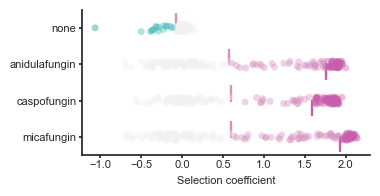

In [32]:
# Purge graph space
sns.set_theme(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

lclasses = ['resistant','intermediary','WT-like','slightly deleterious','deleterious']
custom_palette = ['#C75DAB','#D691C1','#F1F1F1','#42B7B9','#009B9E']

fig = sns.catplot(slpAA, x='s', y='compound', order=['none','anidulafungin','caspofungin','micafungin'],
                  hue='refined_class', hue_order=lclasses, palette=custom_palette, height=2, aspect=2,
                  alpha=.4, legend=False
                 )

sns.boxplot(stddf, x='val', y='compound',
            hue='thresh', hue_order=['low','up'], palette=['#D691C1','#C75DAB'], fill=False,
            legend=False)

fig.set(xlabel='Selection coefficient', ylabel='')
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus])}_classification_stripplot.svg', format='svg', dpi=300)

### Counts / %

In [33]:
perc = GMMdf.groupby(['compound','sensres'])[["aa_seq"]].agg(nb_seq = ("aa_seq", "nunique"),
                                                               )
tot = len(GMMdf.aa_seq.unique())
perc['%'] = perc.apply(lambda row: f'{row.nb_seq/tot:.1%}', axis=1)
perc

nb_seq      %
compound      sensres                   
anidulafungin resistant        87  51.2%
              sensitive        83  48.8%
caspofungin   resistant        91  53.5%
              sensitive        79  46.5%
micafungin    resistant        84  49.4%
              sensitive        86  50.6%
none          deleterious       1   0.6%
              sensitive       169  99.4%

### Show distributions

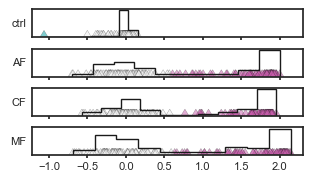

In [34]:
graphdf=GMMdf

abrev_drugs = {'none':'ctrl',
               'dox':'rep. ctrl',
               'anidulafungin':'AF',
               'caspofungin':'CF',
               'micafungin':'MF'
              }
lclasses = ['resistant','sensitive','deleterious']
custom_palette = ['#C75DAB','#F1F1F1','#009B9E']

rc_dict = {'figure.figsize':(3.5,1.9),
      'font.family':'Arial',
      'font.size':8,
      'legend.title_fontsize':8, 'legend.fontsize':8,
      'axes.labelsize':8,'axes.titlesize':8,
      'xtick.labelsize':8, 'ytick.labelsize':8,
      'xtick.major.pad':2, 'ytick.major.pad':2,
      'xtick.bottom': True, 'ytick.left': False,
      'xtick.major.size':2, 'ytick.major.size':2
     }
plt.rcParams.update(rc_dict)
fig, ax = plt.subplots(len(graphdf.compound.unique()),1, sharex=True,
                       gridspec_kw = {'hspace':.4})

for i, c in enumerate([x for x in abrev_drugs.keys() if x in graphdf.compound.unique()]):
    axdf = graphdf[graphdf.compound == c]
    ax[i].hist(axdf.s, histtype='step', color='k')
    ax[i].scatter(axdf.s, np.zeros(axdf.s.shape), marker='d', s=50, c=axdf.sensres.map(dict(zip(lclasses, custom_palette))), edgecolors='k', linewidths=.25, alpha=.5)
    ax[i].set_yticks([])
    ax[i].set_ylabel(abrev_drugs[c], rotation=0, ha='right', va='center')

plt.savefig(f'{graph_outpath}/{"_".join([strain,locus])}_distribution_effects_rug.svg', format='svg', dpi=300)

## UpSet plot on classified variants

In [35]:
parse_dict = {'resistant':True, 'sensitive':False, 'deleterious':False}

In [36]:
BYnnkCompWide = GMMdf.pivot_table(index='aa_seq',
                                    columns='compound',
                                    values=['s','sensres'],
                                    aggfunc='first'
                                   ).reset_index()
BYnnkCompWide['max_s'] = BYnnkCompWide['s'].max(axis=1)
bincat = BYnnkCompWide['sensres'].replace(parse_dict)
bincat.rename(columns={'anidulafungin':'AF',
                       'caspofungin':'CF',
                       'micafungin':'MF',
                       'none':'ctrl'
                      }, inplace=True)
compounds = ['AF','CF','MF']
bincat = pd.concat([bincat, BYnnkCompWide[['max_s']].droplevel(1, axis=1)], axis=1)
bincat

/tmp/ipykernel_40061/3138629034.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bincat = BYnnkCompWide['sensres'].replace(parse_dict)


,AF,CF,MF,ctrl,max_s
0,False,False,False,False,0.462259
1,True,True,True,False,1.839270
2,False,True,True,False,1.786246
3,False,True,True,False,1.812057
4,False,False,False,False,0.472676
...,...,...,...,...,...
165,True,True,True,False,2.080219
166,True,True,True,False,1.771096
167,True,True,True,False,1.978135
168,True,True,True,False,1.955909


In [37]:
bincat.ctrl.unique()

array([False])

In [38]:
bincat.to_csv(f'{classified_outpath}/upsetplot.csv')

In [39]:
bincat = pd.read_csv(f'{classified_outpath}/upsetplot.csv', index_col=0)

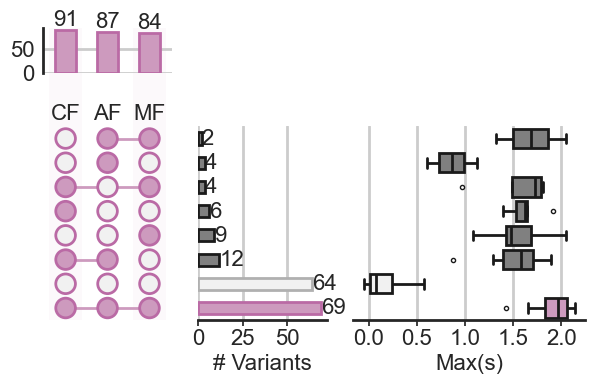

In [40]:
# Manuscript version
# For this plot, all sizes are doubled and the graph is ultimately reduced by 50% for the final panel

rc_dict = {'font.family':'Arial',
           'font.size':16,
           'axes.linewidth': 2, 'grid.linewidth': 2,
           'axes.labelsize':16,'axes.titlesize':16,
           'xtick.labelsize':16, 'ytick.labelsize':16,
           'xtick.major.pad':2, 'ytick.major.pad':2,
           'xtick.major.size':4, 'ytick.major.size':4
          }

upset_obj = UpSet(from_indicators(compounds, data=bincat),
                  orientation='vertical',
                  facecolor='#cd9abe', other_dots_color='#F1F1F1',
                  #show_percentages=True,
                  show_counts=True,
                  #min_subset_size=10,
                  sort_by='cardinality',
                  element_size=None,
                  intersection_plot_elements=3, # height/width of intersection barplot in matrix elements # needs to be 0 to be able to draw stacked_barplot
                  totals_plot_elements = 2, # width/height of totals barplot in matrix elements
                 )

upset_obj.add_catplot(value='max_s', kind='box',
                      color='grey', fliersize=3, linewidth=2, linecolor='k',
                      elements=5 # height in number of matrix elements
                      )

fig = plt.figure(figsize=(7, 3.8))

with plt.rc_context(rc_dict):
    d = upset_obj.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()

axt = d['totals']
axm = d['matrix']
ax0 = d['intersections'] # Key corresponding to stacked barplot ('intersections' = intersection barplot)
ax1 = d['extra1'] # Key corresponding to additional plot, in this case catplot

for i in [0,1,2]:
    axt.get_children()[i].set_color('#cd9abe')
    axt.get_children()[i].set_edgecolor('#ba6aa5')
    axt.get_children()[i].set_linewidth(2)

axm.set_xticklabels(axm.get_xticklabels(), rotation=0, ha='center')
axm.get_children()[0].set_edgecolor('#ba6aa5')
axm.get_children()[0].set_linewidth(2)

ax0.set_xlabel('# Variants') # (unique aminoacid sequences)
ax1.set_xlabel('Max(s)')

if locus=='FKS1-HS1':
    for i in [0,1,2,3,4,5,6,7]:
        ax0.get_children()[i].set_linewidth(2)
        if i <=5:
            ax0.get_children()[i].set_color('grey')
            ax0.get_children()[i].set_edgecolor('k')
        elif i==6:
            ax0.get_children()[i].set_color('#F1F1F1')
            ax0.get_children()[i].set_edgecolor('#b0b0b0')
        else:
            ax0.get_children()[i].set_edgecolor('#ba6aa5')
    
    ax1.get_children()[42].set_facecolor('#F1F1F1')
    ax1.get_children()[49].set_facecolor('#cd9abe')

elif locus=='FKS1-HS2':
    for i in [0,1,2,3,4,5,6]:
        ax0.get_children()[i].set_linewidth(2)
        if i <=4:
            ax0.get_children()[i].set_color('grey')
            ax0.get_children()[i].set_edgecolor('k')
        elif i==5:
            ax0.get_children()[i].set_edgecolor('#ba6aa5')
        else:
            ax0.get_children()[i].set_color('#F1F1F1')
            ax0.get_children()[i].set_edgecolor('#b0b0b0')
    ax1.get_children()[35].set_facecolor('#cd9abe')
    ax1.get_children()[42].set_facecolor('#F1F1F1')

elif locus=='FKS1-HS3':
    for i in [0,1,2,3,4,5,6]:
        ax0.get_children()[i].set_linewidth(2)
        if i <=4:
            ax0.get_children()[i].set_color('grey')
            ax0.get_children()[i].set_edgecolor('k')
        elif i==5:
            ax0.get_children()[i].set_edgecolor('#ba6aa5')
        else:
            ax0.get_children()[i].set_color('#F1F1F1')
            ax0.get_children()[i].set_edgecolor('#b0b0b0')
    
    ax1.get_children()[42].set_facecolor('#F1F1F1')
    ax1.get_children()[35].set_facecolor('#cd9abe')    
    
else:
    print('No support for this hotspot')

plt.savefig(f'{graph_outpath}/upsetplot_resistance_overlap_{strain}_{locus}.svg', format='svg', dpi=300)

## Compare data with FungAMR

In [41]:
# import data from FungAMR for comparison (literature reports)
fungamr = pd.read_csv(fungamr_path, sep='\t')
fungamr = fungamr[(fungamr.locus == locus) & (fungamr.compound.isin(['anidulafungin','caspofungin','micafungin']))] # filter for correct locus
fungamr = fungamr[(fungamr.best_res <=4) | (fungamr.best_sens >= -4)] # exclude low confidence literature reports
fungamr['reported in Scer'] = fungamr.species.str.contains('Saccharomyces cerevisiae')

In [42]:
def bool_cross(x,y):
    if (x not in ['resistant', 'sensitive']) | (y not in ['resistant', 'sensitive']):
        return np.nan
    if x==y:
        if x=='resistant':
            return 'resistant'
        else:
            return 'sensitive'
    else:
        return 'disagreement'

In [43]:
fungamr_merge = pd.merge(left=GMMdf, right=fungamr[['Scer_mutation','aa_seq','compound','phenotype', 'best_res', 'best_sens', 'reported in Scer']], on=['aa_seq','compound'], how='outer')
fungamr_merge['litterature_support'] = fungamr_merge.apply(lambda row: bool_cross(row.sensres, row.phenotype), axis=1)
agreements = fungamr_merge[fungamr_merge.litterature_support.notnull()].pivot_table(index='Scer_mutation',
                                                                       columns='compound',
                                                                       values='litterature_support',
                                                                       aggfunc='first'
                                                                      )
best_scores = fungamr_merge[fungamr_merge.litterature_support.notnull()].pivot_table(index='Scer_mutation',
                                                                       columns='compound',
                                                                       values=['best_res','best_sens','reported in Scer'],
                                                                       aggfunc='first'
                                                                      )
best_res = best_scores[[x for x in best_scores.columns if x[0] == 'best_res']].min(axis=1)
best_sens = best_scores[[x for x in best_scores.columns if x[0] == 'best_sens']].max(axis=1)
Scer_rep = best_scores[[x for x in best_scores.columns if x[0] == 'reported in Scer']].any(axis=1)
agreements['best_res_across'] = best_res
agreements['best_sens_across'] = best_sens
agreements['reported in Scer'] = Scer_rep
agreements

compound,anidulafungin,caspofungin,micafungin,best_res_across,best_sens_across,reported in Scer
Scer_mutation,,,,,,
F639S,resistant,resistant,resistant,4.0,-8.0,False
F639V,NaN,resistant,resistant,1.0,NaN,True
F639Y,NaN,resistant,resistant,2.0,-8.0,True
L642Y,NaN,resistant,NaN,1.0,NaN,False
P647A,resistant,resistant,resistant,1.0,NaN,True
P647L,disagreement,disagreement,disagreement,NaN,-1.0,False
R645G,disagreement,disagreement,resistant,1.0,-1.0,False
S643F,resistant,resistant,resistant,4.0,-8.0,False
S643P,resistant,resistant,resistant,1.0,-8.0,False


In [44]:
agreements.to_csv(f"{fungamr_outpath}/agreements_{strain}_{locus}.csv")